In [4]:
import pandas as pd
import numpy as np
from pymongo import MongoClient
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set plot style for better visualization
plt.style.use('seaborn-v0_8')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('muted')


In [5]:
client = MongoClient("mongodb://localhost:27017/")
db = client["recommender_system"] 

collection = db["admissions"]
data = list(collection.find())
admissions = pd.DataFrame(data)

collection = db["patients"]
data = list(collection.find())
patients = pd.DataFrame(data)

collection = db["diagnoses_icd"]
data = list(collection.find())
diagnoses_icd = pd.DataFrame(data)

collection = db["procedures_icd"]
data = list(collection.find())
procedures_icd = pd.DataFrame(data)


In [7]:
 # --- 1. Data Overview --- 
print("Admissions Shape:", admissions.shape)
print("Patients Shape:", patients.shape)
print("Diagnoses ICD Shape:", diagnoses_icd.shape)
print("Procedures ICD Shape:", procedures_icd.shape)

Admissions Shape: (283, 16)
Patients Shape: (262, 7)
Diagnoses ICD Shape: (3130, 6)
Procedures ICD Shape: (510, 7)


In [8]:
# Display first few rows
print("\nAdmissions Head:\n", admissions.head())
print("\nPatients Head:\n", patients.head())
print("\nDiagnoses ICD Head:\n", diagnoses_icd.head())
print("\nProcedures ICD Head:\n", procedures_icd.head())



Admissions Head:
                         _id  subject_id   hadm_id            admittime  \
0  67c4cb3a44a7421d696860bf    10046543  21402025  2155-03-15 21:22:00   
1  67c4cb3a44a7421d6968776b    10188106  28288574  2155-03-26 23:55:00   
2  67c4cb3a44a7421d6968776c    10188106  29174671  2155-03-22 17:26:00   
3  67c4cb3a44a7421d69687aa1    10207914  21364683  2155-03-22 05:06:00   
4  67c4cb3a44a7421d696880ba    10247468  21915776  2155-03-13 04:10:00   

             dischtime  admission_type                  admission_location  \
0  2155-03-20 17:00:00  EU OBSERVATION               WALK-IN/SELF REFERRAL   
1  2155-05-28 19:30:00          URGENT  INTERNAL TRANSFER TO OR FROM PSYCH   
2  2155-03-26 23:55:00        EW EMER.                      EMERGENCY ROOM   
3  2155-03-28 18:00:00        EW EMER.                      EMERGENCY ROOM   
4  2155-03-17 15:25:00        EW EMER.                      EMERGENCY ROOM   

  insurance language marital_status   race            edregtime  \


# 2. Data Cleaning

In [9]:
# Check for missing values
print("\n--- Missing Values ---")
print("Admissions:\n", admissions.isnull().sum())
print("Patients:\n", patients.isnull().sum())
print("Diagnoses ICD:\n", diagnoses_icd.isnull().sum())
print("Procedures ICD:\n", procedures_icd.isnull().sum())



--- Missing Values ---
Admissions:
 _id                       0
subject_id                0
hadm_id                   0
admittime                 0
dischtime                 0
admission_type            0
admission_location        0
insurance                 0
language                  0
marital_status            8
race                      0
edregtime                93
edouttime                93
hospital_expire_flag      0
discharge_location       75
deathtime               271
dtype: int64
Patients:
 _id                    0
subject_id             0
gender                 0
anchor_age             0
anchor_year            0
anchor_year_group      0
dod                  195
dtype: int64
Diagnoses ICD:
 _id            0
subject_id     0
hadm_id        0
seq_num        0
icd_code       0
icd_version    0
dtype: int64
Procedures ICD:
 _id            0
subject_id     0
hadm_id        0
seq_num        0
chartdate      0
icd_code       0
icd_version    0
dtype: int64


In [10]:
# Drop rows with critical missing values (e.g., subject_id, hadm_id)
admissions = admissions.dropna(subset=['subject_id', 'hadm_id'])
diagnoses_icd = diagnoses_icd.dropna(subset=['subject_id', 'hadm_id', 'icd_code'])
procedures_icd = procedures_icd.dropna(subset=['subject_id', 'hadm_id', 'icd_code'])

In [12]:
patients

,_id,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,6853ae6587fd170a1dfebea0,10046543,F,91,2155,2017 - 2019,NaT
1,6853ae6587fd170a1dfebea1,10188106,M,39,2151,2011 - 2013,NaT
2,6853ae6587fd170a1dfebea2,10207914,M,22,2155,2008 - 2010,NaT
3,6853ae6587fd170a1dfebea3,10247468,M,23,2155,2008 - 2010,NaT
4,6853ae6587fd170a1dfebea4,10261732,F,79,2155,2011 - 2013,2155-03-24
...,...,...,...,...,...,...,...
257,6853ae6587fd170a1dfebfa1,19562159,F,81,2155,2017 - 2019,NaT
258,6853ae6587fd170a1dfebfa2,19638442,F,47,2151,2008 - 2010,NaT
259,6853ae6587fd170a1dfebfa3,19672997,F,66,2155,2011 - 2013,2155-05-02
260,6853ae6587fd170a1dfebfa4,19895627,F,53,2154,2011 - 2013,NaT


In [13]:
# Convert dates to datetime
admissions['admittime'] = pd.to_datetime(admissions['admittime'])
admissions['dischtime'] = pd.to_datetime(admissions['dischtime'])
patients['dod'] = pd.to_datetime(patients['dod'], errors='coerce')

In [14]:
# Calculate length of stay
admissions['los'] = (admissions['dischtime'] - admissions['admittime']).dt.total_seconds() / (24 * 3600)  # in days

In [16]:
patients

,_id,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,6853ae6587fd170a1dfebea0,10046543,F,91,2155,2017 - 2019,NaT
1,6853ae6587fd170a1dfebea1,10188106,M,39,2151,2011 - 2013,NaT
2,6853ae6587fd170a1dfebea2,10207914,M,22,2155,2008 - 2010,NaT
3,6853ae6587fd170a1dfebea3,10247468,M,23,2155,2008 - 2010,NaT
4,6853ae6587fd170a1dfebea4,10261732,F,79,2155,2011 - 2013,2155-03-24
...,...,...,...,...,...,...,...
257,6853ae6587fd170a1dfebfa1,19562159,F,81,2155,2017 - 2019,NaT
258,6853ae6587fd170a1dfebfa2,19638442,F,47,2151,2008 - 2010,NaT
259,6853ae6587fd170a1dfebfa3,19672997,F,66,2155,2011 - 2013,2155-05-02
260,6853ae6587fd170a1dfebfa4,19895627,F,53,2154,2011 - 2013,NaT


In [17]:
# Calculate age at admission using anchor_age, anchor_year, and admission year
# Merge anchor_age and anchor_year from patients to admissions
admissions = admissions.merge(
    patients[['subject_id', 'anchor_age', 'anchor_year']],
    on='subject_id',
    how='left'
)

# Extract admission year from admittime
admissions['admission_year'] = admissions['admittime'].dt.year

# Calculate age: anchor_age + (admission_year - anchor_year)
admissions['age'] = admissions['anchor_age'] + (admissions['admission_year'] - admissions['anchor_year'])

# Handle invalid ages (e.g., negative or unrealistic)
admissions['age'] = admissions['age'].apply(lambda x: x if 0 <= x <= 120 else np.nan)

# Aggregate age at patient level (use median age across admissions to handle multiple admissions)
patient_age = admissions.groupby('subject_id')['age'].median().reset_index(name='age')
patients = patients.merge(patient_age, on='subject_id', how='left')

In [18]:
patients

,_id,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod,age
0,6853ae6587fd170a1dfebea0,10046543,F,91,2155,2017 - 2019,NaT,91.0
1,6853ae6587fd170a1dfebea1,10188106,M,39,2151,2011 - 2013,NaT,43.0
2,6853ae6587fd170a1dfebea2,10207914,M,22,2155,2008 - 2010,NaT,22.0
3,6853ae6587fd170a1dfebea3,10247468,M,23,2155,2008 - 2010,NaT,23.0
4,6853ae6587fd170a1dfebea4,10261732,F,79,2155,2011 - 2013,2155-03-24,79.0
...,...,...,...,...,...,...,...,...
257,6853ae6587fd170a1dfebfa1,19562159,F,81,2155,2017 - 2019,NaT,81.0
258,6853ae6587fd170a1dfebfa2,19638442,F,47,2151,2008 - 2010,NaT,51.0
259,6853ae6587fd170a1dfebfa3,19672997,F,66,2155,2011 - 2013,2155-05-02,66.0
260,6853ae6587fd170a1dfebfa4,19895627,F,53,2154,2011 - 2013,NaT,54.0


# 3. Merge Data for Unified Analysis

In [19]:
df = admissions.merge(patients[['subject_id', 'gender', 'age']], on='subject_id', how='left')

In [20]:
# Merge with diagnoses_icd
diagnoses_icd_agg = diagnoses_icd.groupby(['subject_id', 'hadm_id'])['icd_code'].apply(lambda x: list(x)).reset_index(name='diagnoses')
df = df.merge(diagnoses_icd_agg, on=['subject_id', 'hadm_id'], how='left')

In [21]:
# Merge with procedures_icd
procedures_icd_agg = procedures_icd.groupby(['subject_id', 'hadm_id'])['icd_code'].apply(lambda x: list(x)).reset_index(name='procedures')
df = df.merge(procedures_icd_agg, on=['subject_id', 'hadm_id'], how='left')

In [22]:
print("\nMerged Data Shape:", df.shape)
print("\nMerged Data Head:\n", df.head())


Merged Data Shape: (283, 25)

Merged Data Head:
                         _id  subject_id   hadm_id           admittime  \
0  67c4cb3a44a7421d696860bf    10046543  21402025 2155-03-15 21:22:00   
1  67c4cb3a44a7421d6968776b    10188106  28288574 2155-03-26 23:55:00   
2  67c4cb3a44a7421d6968776c    10188106  29174671 2155-03-22 17:26:00   
3  67c4cb3a44a7421d69687aa1    10207914  21364683 2155-03-22 05:06:00   
4  67c4cb3a44a7421d696880ba    10247468  21915776 2155-03-13 04:10:00   

            dischtime  admission_type                  admission_location  \
0 2155-03-20 17:00:00  EU OBSERVATION               WALK-IN/SELF REFERRAL   
1 2155-05-28 19:30:00          URGENT  INTERNAL TRANSFER TO OR FROM PSYCH   
2 2155-03-26 23:55:00        EW EMER.                      EMERGENCY ROOM   
3 2155-03-28 18:00:00        EW EMER.                      EMERGENCY ROOM   
4 2155-03-17 15:25:00        EW EMER.                      EMERGENCY ROOM   

  insurance language marital_status  ... deathti

# 4. Exploratory Data Analysis

## 4.1 Patient Demographics

In [23]:
print("\n--- Patient Demographics ---")
print("Gender Distribution:\n", patients['gender'].value_counts(normalize=True))
print("Age Statistics:\n", patients['age'].describe())



--- Patient Demographics ---
Gender Distribution:
 gender
F    0.522901
M    0.477099
Name: proportion, dtype: float64
Age Statistics:
 count    262.000000
mean      59.072519
std       20.035564
min       18.000000
25%       45.000000
50%       61.000000
75%       73.750000
max       98.000000
Name: age, dtype: float64


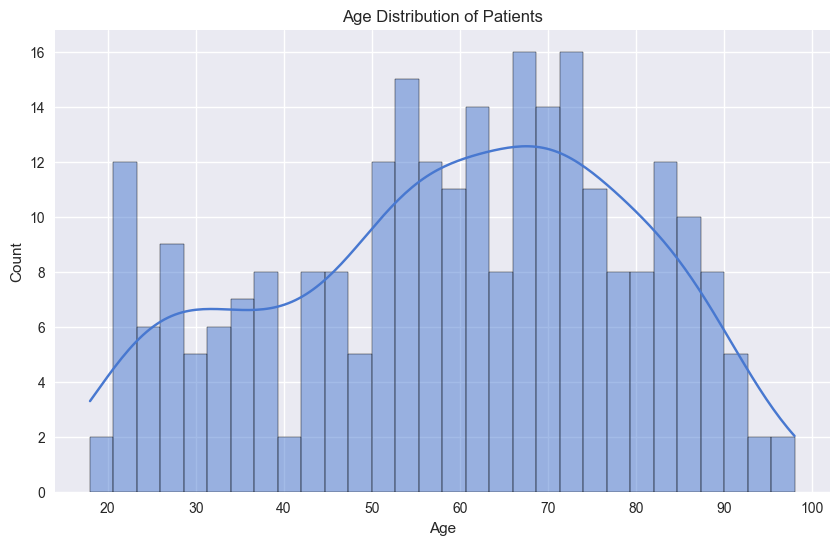

In [27]:
# Plot age distribution
plt.figure(figsize=(10, 6))
sns.histplot(patients['age'].dropna(), bins=30, kde=True)
plt.title('Age Distribution of Patients')
plt.xlabel('Age')
plt.ylabel('Count')
plt.savefig('age_distribution.png')
plt.show()
plt.close()

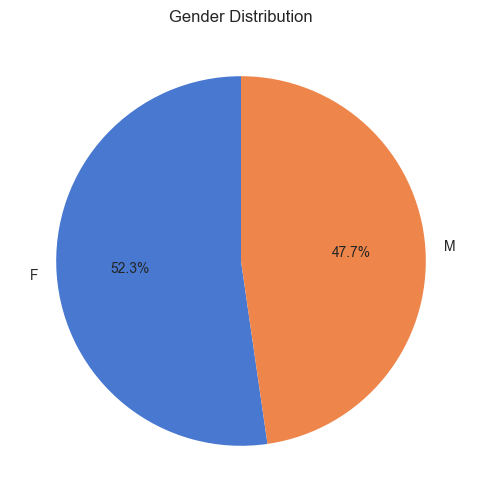

In [28]:
# Plot Patient's gender distribution
plt.figure(figsize=(6, 6))
patients['gender'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Gender Distribution')
plt.ylabel('')
plt.savefig('gender_distribution.png')
plt.show()
plt.close()

In [29]:
# Admission Patterns
print("\n--- Admission Patterns ---")
print("Admission Type Distribution:\n", admissions['admission_type'].value_counts(normalize=True))
print("Length of Stay Statistics:\n", admissions['los'].describe())


--- Admission Patterns ---
Admission Type Distribution:
 admission_type
EW EMER.                       0.332155
EU OBSERVATION                 0.219081
OBSERVATION ADMIT              0.120141
URGENT                         0.113074
DIRECT EMER.                   0.070671
SURGICAL SAME DAY ADMISSION    0.063604
DIRECT OBSERVATION             0.035336
ELECTIVE                       0.024735
AMBULATORY OBSERVATION         0.021201
Name: proportion, dtype: float64
Length of Stay Statistics:
 count    283.000000
mean       4.802945
std        6.394462
min        0.031250
25%        1.477083
50%        2.826389
75%        5.205208
max       62.815972
Name: los, dtype: float64


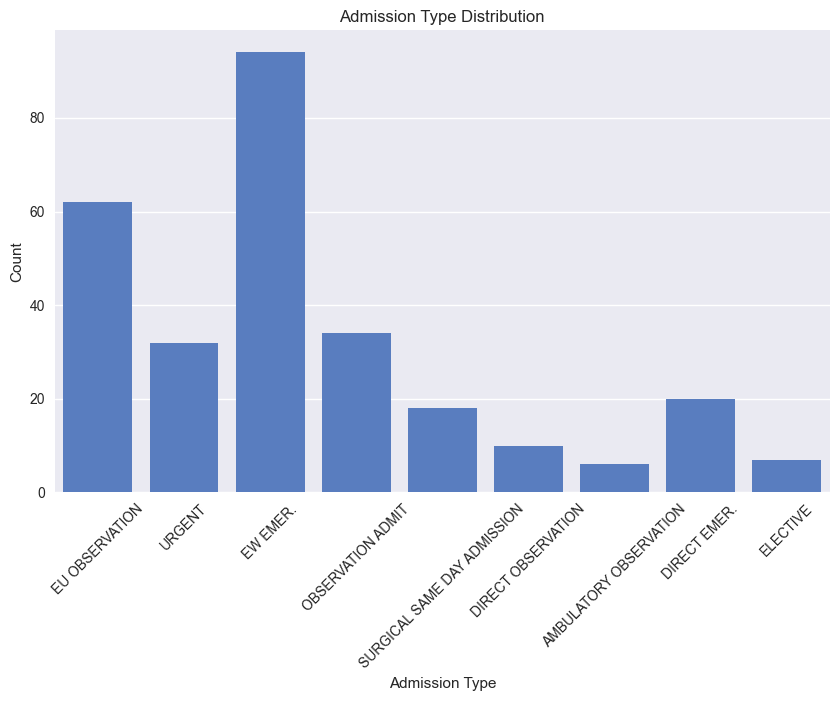

In [30]:
# Plot admission type
plt.figure(figsize=(10, 6))
sns.countplot(x='admission_type', data=admissions)
plt.title('Admission Type Distribution')
plt.xlabel('Admission Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.savefig('charts/admission_type.png')
plt.show()
plt.close()


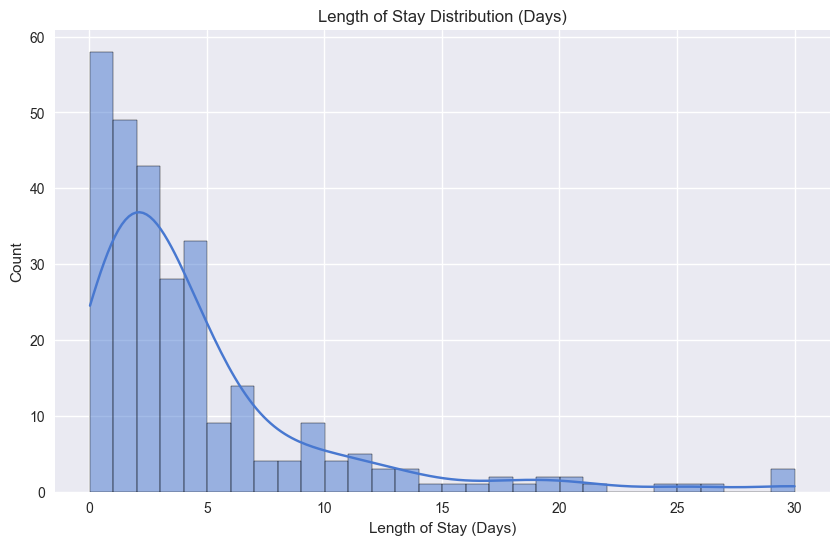

In [31]:

# Plot length of stay
plt.figure(figsize=(10, 6))
sns.histplot(admissions['los'].clip(upper=30), bins=30, kde=True)  # Clip outliers for visualization
plt.title('Length of Stay Distribution (Days)')
plt.xlabel('Length of Stay (Days)')
plt.ylabel('Count')
plt.savefig('charts/los_distribution.png')
plt.show()
plt.close()

In [32]:

# 4.3 Diagnoses Analysis
# Flatten diagnoses list for frequency analysis
all_diagnoses = diagnoses_icd['icd_code'].value_counts().head(10)
print("\n--- Top 10 Diagnoses (ICD Codes) ---")
print(all_diagnoses)

# Plot top diagnoses
plt.figure(figsize=(12, 6))
all_diagnoses.plot(kind='bar')
plt.title('Top 10 Most Frequent Diagnoses (ICD-10 Codes)')
plt.xlabel('ICD-10 Code')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.savefig('top_diagnoses.png')
plt.close()

# 4.4 Procedures Analysis
# Flatten procedures list for frequency analysis
all_procedures = procedures_icd['icd_code'].value_counts().head(10)
print("\n--- Top 10 Procedures (ICD Codes) ---")
print(all_procedures)

# Plot top procedures
plt.figure(figsize=(12, 6))
all_procedures.plot(kind='bar')
plt.title('Top 10 Most Frequent Procedures (ICD-10 Codes)')
plt.xlabel('ICD-10 Code')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.savefig('top_procedures.png')
plt.close()

# 4.5 Correlation Analysis
# Number of diagnoses and procedures per admission
df['num_diagnoses'] = df['diagnoses'].apply(lambda x: len(x) if isinstance(x, list) else 0)
df['num_procedures'] = df['procedures'].apply(lambda x: len(x) if isinstance(x, list) else 0)

print("\n--- Correlation Analysis ---")
print("Correlation between Number of Diagnoses, Procedures, and LOS:\n",
      df[['num_diagnoses', 'num_procedures', 'los']].corr())

# Scatter plot: Diagnoses vs. LOS
plt.figure(figsize=(10, 6))
sns.scatterplot(x='num_diagnoses', y='los', data=df, alpha=0.5)
plt.title('Number of Diagnoses vs. Length of Stay')
plt.xlabel('Number of Diagnoses')
plt.ylabel('Length of Stay (Days)')
plt.savefig('diagnoses_vs_los.png')
plt.close()

# Save merged dataset for further analysis
df.to_csv('mimic_merged_data.csv', index=False)
print("\nMerged dataset saved as 'mimic_merged_data.csv' for further analysis.")


--- Top 10 Diagnoses (ICD Codes) ---
icd_code
4019      63
53081     37
2724      36
E785      34
4280      30
I10       29
25000     27
41401     26
Z87891    25
42731     25
Name: count, dtype: int64

--- Top 10 Procedures (ICD Codes) ---
icd_code
5491       11
3893        9
8856        8
331         8
3891        8
966         6
9671        6
0BH17EZ     5
7569        5
02HV33Z     5
Name: count, dtype: int64

--- Correlation Analysis ---
Correlation between Number of Diagnoses, Procedures, and LOS:
                 num_diagnoses  num_procedures       los
num_diagnoses        1.000000        0.479771  0.589344
num_procedures       0.479771        1.000000  0.536438
los                  0.589344        0.536438  1.000000

--- Insights for Recommender System ---
1. Patient demographics show a balanced gender distribution and a wide age range, suitable for patient similarity calculations.
2. Admission types and LOS vary significantly, indicating diverse patient needs that the recommen